In this notebook, we will fine-tune Idefics2 with DoRA. We will replace every linear layer in the LLM with a DoRA adapter layer. DoRA is similar to LoRA but decomposes the low rank adapters into their magnitude and direction. Therefore, DoRA has more trainable parameters compared to LoRA but is supposed to increase performance.

In [2]:
!pip install transformers datasets accelerate bitsandbytes peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


We start by importing the ScienceQA dataset from HuggingFace. The answers are given as integers but we have to transform them into strings to fine-tune the model.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

(…)-00000-of-00001-1028f23e353fbe3e.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

(…)-00000-of-00001-6c7328ff6c84284c.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

(…)-00000-of-00001-f0e719df791966ff.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12726 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4241 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4241 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6218 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2097 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2017 [00:00<?, ? examples/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=202x202>,
 'question': "Which animal's feet are also adapted for grabbing prey?",
 'choices': ['sable', 'New Zealand falcon'],
 'answer': '1',
 'hint': "Bald eagles eat fish, mammals, and other birds. The 's feet are adapted for grabbing prey.\nFigure: bald eagle.",
 'task': 'closed choice',
 'grade': 'grade5',
 'subject': 'natural science',
 'topic': 'biology',
 'category': 'Adaptations',
 'skill': 'Animal adaptations: feet and limbs',
 'lecture': "An adaptation is an inherited trait that helps an organism survive or reproduce. Adaptations can include both body parts and behaviors.\nThe shape of an animal's feet is one example of an adaptation. Animals' feet can be adapted in different ways. For example, webbed feet might help an animal swim. Feet with thick fur might help an animal walk on cold, snowy ground.",
 'solution': 'Look at the picture of the bald eagle.\nThe bald eagle has long toes with sharp claws. Its feet ar

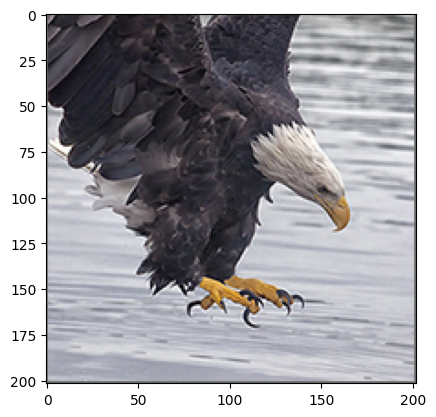

In [3]:
from datasets import load_dataset, Value
import matplotlib.pyplot as plt

ds = load_dataset("derek-thomas/ScienceQA")
ds = ds.filter(lambda example: example['image'] is not None) #only keep obs with images
ds = ds.cast_column('answer', Value("string")) #convert answer from int to string
example = ds['validation'][3]
plt.imshow(example['image'])#.resize((100, 100), Image.Resampling.LANCZOS))
example

Next we define the train and validation datasets.

In [4]:
train_dataset = ds['train']
train_dataset = train_dataset.remove_columns(['hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'])

eval_dataset = ds['validation']
eval_dataset = eval_dataset.remove_columns(['hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'])

Question: Which term matches the picture?
Choices: ['appendicular skeleton', 'axial skeleton']
Answer: 1


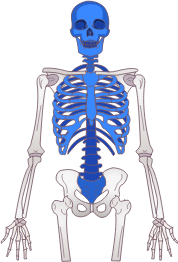

In [5]:
val_example = eval_dataset[16]
image, question, choices, answer = val_example['image'], val_example['question'], val_example['choices'], val_example['answer']
print("Question:", question)
print("Choices:", choices)
print("Answer:", answer)
image

We load in the Idefics2 model and processor from HuggingFace. We use the version with 8b parameters to have a model small enough to fit on consumer hardware. We will also quantize the model (store it in a 4-bit format) to reduce the memory overhead.

In [6]:
from transformers import AutoProcessor, AutoTokenizer, Idefics2ForConditionalGeneration, BitsAndBytesConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Load in the processor which formats inputs for LLaVa
processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False, size= {"longest_edge": 448, "shortest_edge": 378})
# processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

# Tokenizer
IDEFICS2_CHAT_TEMPLATE = """{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. {% for message in messages %}{% if message['role'] == 'user' %}USER: {% else %}ASSISTANT: {% endif %}{% for item in message['content'] %}{% if item['type'] == 'text' %}{{ item['text'] }}{% elif item['type'] == 'image' %}<image>{% endif %}{% endfor %}{% if message['role'] == 'user' %} {% else %}{{eos_token}}{% endif %}{% endfor %}{% if add_generation_prompt %}ASSISTANT: {% endif %}"""
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceM4/idefics2-8b", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.chat_template = IDEFICS2_CHAT_TEMPLATE

# We will us QLoRa, so we specify how to quantize the model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = Idefics2ForConditionalGeneration.from_pretrained("HuggingFaceM4/idefics2-8b",
                                                         torch_dtype=torch.float16,
                                                         quantization_config=quantization_config).to(device)



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

cuda


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.jinja' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Now that the model is loaded in, we identify every linear layer of the model and add the DoRa adapter layers. These layers will be trained in place of the model. We will use a rank of 6 (we use lower rank than fine-tuning with LoRA because there are more trainable parameters and using a rank of 8 would exceed our VRAM capacity).

In [7]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model


def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

lora_config = LoraConfig(
    r=6,
    lora_alpha=6,
    lora_dropout=0.05,
    # target_modules=find_all_linear_names(model),
    target_modules=".*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$",
    init_lora_weights="gaussian",
    use_dora=True,
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

Examine the number of trainable parameters.

In [8]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param}"
    )

In [9]:
print_trainable_parameters(model)

trainable params: 19,033,856 || all params: 4,355,147,760 || trainable%: 0.43704271471147516


Before we start fine-tuning, we must define the collate function. This will inform the trainer how to batch training examples. We format the question, choices, and answer of each observations into a prompt format the the model accepts. 

In [10]:
class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            if image is None:
                continue
            question = example["question"]
            choices = example["choices"]
            answer = example["answer"]

            content = [{"type": "text", "text": "Please read the multiple-choice question below carefully and answer only with an index of the given list of choices."}]
            content += [{"type": "image"}]
            content += [{"type": "text", "text": f"{question}\nThe choices are: {choices}."}]

            messages = [
                {
                    "role": "user",
                    "content": content,
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True, max_length=512)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        labels[labels == model.config.image_token_id] = -100
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)

We verify that the data collator works as intended.

In [11]:
batch = data_collator.__call__((train_dataset[0], train_dataset[1]))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2691: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [12]:
processor.batch_decode(batch['input_ids'])

["<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><s> User: Please read the multiple-choice question below carefully and answer only with an index of the given list of choices.<fake_token_around_image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><fake_token_around_image> Which of these states is farthest north?\nThe choices are: ['West Virginia', 'Louisiana', 'Arizona', 'Oklahoma'].<end_of_utterance> \

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Now we can define the parameters for fine-tuning and train the model. Due to time and memory constraints, we will only train the model for 2 epochs and use a batch size of 3. However, we accumulate the gradients over 8 steps. This results in an effective batch size of 24.

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    output_dir="/content/gdrive/My Drive/Idefics2_dora_ft",
    save_strategy="steps",
    save_steps=75,
    save_total_limit=1,
    # evaluation_strategy="epoch",
    fp16=True,
    push_to_hub=False,
    remove_unused_columns=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
)

In [16]:
trainer.train(resume_from_checkpoint=True)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
325,0.119900
350,0.116700
375,0.117700
400,0.116900
425,0.117000
450,0.111800
475,0.114600
500,0.103600


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2691: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2691: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dis

TrainOutput(global_step=518, training_loss=0.048137925996743575, metrics={'train_runtime': 16447.067, 'train_samples_per_second': 0.756, 'train_steps_per_second': 0.031, 'total_flos': 9.44528134582368e+16, 'train_loss': 0.048137925996743575, 'epoch': 1.9995176073323684})